In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
from numba import jit, objmode, threading_layer, config
import psutil
from netCDF4 import Dataset
from name_list_jupiter import *
from IPython.display import HTML
import helper_functions_MPI as hf
import os

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

matplotlib.rcParams['animation.embed_limit'] = 2**128


def animate(files, element):
    """
    Takes multple files (i.e files = ['data1.nc', 'data2.nc', ...]) and produces a single smooth animation 
    This has taken the place of all the animate, animate_zeta1/zeta2, and animate_two. Since it will do all those
    
    possible elements are: "u1mat","u2mat","v1mat","v2mat","h1mat","h2mat", "zeta1", "zeta2"

    Note the zetas are relative vorticity.
    """
    rootgroups = []
    for file in files:
        rootgroups.append(Dataset(file, "r"))
        
    sampfreq = rootgroups[0].sampfreq
    t0 = rootgroups[0].__dict__["time"]

    if element == "PV1" or element == "zeta1":
        u1mat = np.array(rootgroups[0].variables['u1mat'])
        v1mat = np.array(rootgroups[0].variables['v1mat'])
        h1mat = np.array(rootgroups[0].variables['h1mat'])
        for i in range(1,len(rootgroups)):
            u1 = np.array(rootgroups[i].variables["u1mat"]) 
            v1 = np.array(rootgroups[i].variables["v1mat"])
            h1 = np.array(rootgroups[i].variables["h1mat"])

            u1mat = np.append(u1mat, u1[1:], axis=0)
            v1mat = np.append(v1mat, v1[1:], axis=0)
            h1mat = np.append(h1mat, h1[1:], axis=0)

        if element == "PV1":
            PV1 = (1 - Bt * rdist**2 + (1 / dx) * (v1mat[:] - v1mat[:,:,lg] + u1mat[:,lg,:] - u1mat[:]))/h1mat
        if element == "zeta1":
            PV1 = (1 / dx) * (v1mat[:] - v1mat[:,:,lg] + u1mat[:,lg,:] - u1mat[:])
        frames = PV1
    
    elif element == "PV2" or element == "zeta2":
        u2mat = np.array(rootgroups[0].variables['u2mat'])
        v2mat = np.array(rootgroups[0].variables['v2mat'])
        h2mat = np.array(rootgroups[0].variables['h2mat'])
        for i in range(1,len(rootgroups)):
            u2 = np.array(rootgroups[i].variables["u2mat"]) 
            v2 = np.array(rootgroups[i].variables["v2mat"])
            h2 = np.array(rootgroups[i].variables["h2mat"])

            u2mat = np.append(u2mat, u2[1:], axis=0)
            v2mat = np.append(v2mat, v2[1:], axis=0)
            h2mat = np.append(h2mat, h2[1:], axis=0)
        
        if element == "PV2":
            PV2 = (1 - Bt * rdist**2 + (1 / dx) * (v2mat[:] - v2mat[:,:,lg] + u2mat[:,lg,:] - u2mat[:]))/h2mat
        if element == "zeta2":
            PV2 = (1 / dx) * (v2mat[:] - v2mat[:,:,lg] + u2mat[:,lg,:] - u2mat[:])
        frames = PV2
        
    
    elif element == 'zonal1':
        u1mat = np.array(rootgroups[0].variables['u1mat'])
        v1mat = np.array(rootgroups[0].variables['v1mat'])
        for i in range(1,len(rootgroups)):
            u1 = np.array(rootgroups[i].variables["u1mat"]) 
            v1 = np.array(rootgroups[i].variables["v1mat"])

            u1mat = np.append(u1mat, u1[1:], axis=0)
            v1mat = np.append(v1mat, v1[1:], axis=0)
        
        x, y = np.meshgrid(np.arange(0, N) * dx - L / 2, np.arange(0, N) * dx - L / 2)

        zonal = 1/np.sqrt(x**2 + y**2) * (-y*u1mat + x*v1mat)
        frames = zonal
    
    elif element == 'zonal2':
        u2mat = np.array(rootgroups[0].variables['u2mat'])
        v2mat = np.array(rootgroups[0].variables['v2mat'])
        for i in range(1,len(rootgroups)):
            u2 = np.array(rootgroups[i].variables["u2mat"]) 
            v2 = np.array(rootgroups[i].variables["v2mat"])

            u2mat = np.append(u2mat, u2[1:], axis=0)
            v2mat = np.append(v2mat, v2[1:], axis=0)
        
        x, y = np.meshgrid(np.arange(0, N) * dx - L / 2, np.arange(0, N) * dx - L / 2)

        zonal = 1/np.sqrt(x**2 + y**2) * (-y*u2mat + x*v2mat)
        frames = zonal
        
    else:
        frames = np.array(rootgroups[0].variables[element])
        for i in range(1,len(rootgroups)):
            data = np.array(rootgroups[i].variables[element])

            frames = np.append(frames, data, axis=0)
        
    for group in rootgroups:
        group.close()
        
    
    x, y = np.meshgrid(np.arange(0, N) * dx - L / 2, np.arange(0, N) * dx - L / 2)
        
    print(frames.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    frameslen = int(len(frames))
    cv0 = frames[0]
    vminlist = []
    vmaxlist = []
    for j in frames:
        if math.isnan(j[0, 0]) == False:
            vminlist.append(np.min(j))
            vmaxlist.append(np.max(j))
    vmin = np.min(vminlist)
    vmax = np.max(vmaxlist)
    rang = np.max([vmax, -vmin])
    im = ax.pcolormesh(x,y, cv0, cmap="bwr", shading='auto', vmin=-rang, vmax=rang) #vmin=-0.05, vmax=0.05) #FIX THIS SO XY TICKS
    cb = fig.colorbar(im)
    ax.set_xlabel("x position [LD2]")
    ax.set_ylabel("y position [LD2]")
    tx = ax.set_title(f"{element}, time: {0}")

    def animate(i):
        arr = np.array(frames[i]) #frames[7 * i + (i - 1)]
        vmax = np.max(arr)
        vmin = np.min(arr)
        tx.set_text(f"{element}, time: {round(((i*sampfreq)/f0)/(60*60*24),3)} days")
        im.set_array(arr.ravel())

    ani = animation.FuncAnimation(fig, animate, interval=ani_interval, frames=frameslen)
        
    return ani


In [2]:
data_folder = '100724'

data = os.listdir(data_folder)

fixed = []
for file in data:
    if file[0] == 'j':
        fixed.append(data_folder + '/' + file)
    
def filenum(file):
    return file[-6:-3]

def filenumtxt(file):
    return file[-7:-4]

data = fixed
data = sorted(data, key = filenum)

root = Dataset(data[-1], "r") 

t = root.__dict__["time"]
Ep = root.EpHat

H1H2 = root.H1H2
p1p2 = root.p1p2
c12h = root.c12h
c22h = root.c22h
L = root.L
N = root.N
dx = root.dx

print(f"time ind: {t}, actual time: {round(((t)/f0)/(60*60*24),3)} days, energy: {Ep}")

root.close()

#data = data[9:]
#data


time ind: 160599.45395999998, actual time: 5285.158 days, energy: 0.003265086415506139


In [3]:
#data = ['jupiter140824_1.nc']

In [4]:
ani = animate(data, 'zeta2')
plt.gca().set_aspect('equal')
HTML(ani.to_jshtml())

KeyboardInterrupt: 

In [ ]:
#ani.save("Jupiter_PV2.mp4")

In [ ]:
plt.show()


In [7]:
def ape_ke(files, folder, H1H2, p1p2, c12h, c22h, L):
    
    KEfiles = []
    APEfiles = []
    
    allfiles = os.listdir(folder)
    
    nums = []
    for file in allfiles:
        if file[0] == "K":
            KEfiles.append(folder + '/' + file)
            nums.append(filenumtxt(file))
        
        elif file[0] == "A":
            APEfiles.append(folder + '/' + file)
        
    rootgroups = []
    createnums = []
    for file in files:
        if filenum(file) not in nums:
            rootgroups.append(Dataset(file, "r"))
            createnums.append(filenum(file))
            
    print(f"loaded unsaved data: {createnums}")    
    
    for i in range(len(rootgroups)):
        print(f"saving unsaved data: {createnums[i]}")
        u1 = np.array(rootgroups[i].variables['u1mat'][1:])
        u2 = np.array(rootgroups[i].variables['u2mat'][1:])
        v1 = np.array(rootgroups[i].variables['v1mat'][1:])
        v2 = np.array(rootgroups[i].variables['v2mat'][1:])
        h1 = np.array(rootgroups[i].variables['h1mat'][1:])
        h2 = np.array(rootgroups[i].variables['h2mat'][1:])
       
        KE = []
        APE = []
        for j in range(len(u1)):
            KE.append(hf.calculate_KE(u1[j],u2[j],v1[j],v2[j],h1[j],h2[j], H1H2, p1p2)/L**2)
            APE.append(hf.calculate_APE(h1[j], h2[j], H1H2, p1p2, c12h, c22h)/L**2)
        
        np.savetxt(data_folder + '/' + 'KE_' + createnums[i] + '.txt', KE)
        np.savetxt(data_folder + '/' + 'APE_' + createnums[i] + '.txt', APE)
    
    for group in rootgroups:
            group.close()
            
    
    allfiles = os.listdir(folder)
    
    rootgroups = []
    filenums = []
    for file in files: 
        filenums.append(filenum(file))
    
    KE = np.array([])
    APE = np.array([])
    KEfiles = []
    APEfiles = []
    for file in allfiles:
        if file[0] == "K" and filenumtxt(file) in filenums:
            KEfiles.append(file)
        
        elif file[0] == "A" and filenumtxt(file) in filenums:
            APEfiles.append(file)
                
    KEfiles = sorted(KEfiles, key=filenumtxt)
    APEfiles = sorted(APEfiles, key=filenumtxt)
    
    KE = np.array([])
    APE = np.array([])
    for file in KEfiles:
        KE = np.append(KE, np.loadtxt(data_folder + '/' + file))
    for file in APEfiles:
        APE = np.append(APE, np.loadtxt(data_folder + '/' + file))
    
    return KE, APE

In [8]:
KE,APE = ape_ke(data, data_folder, H1H2, p1p2, c12h, c22h, L)

loaded unsaved data: []


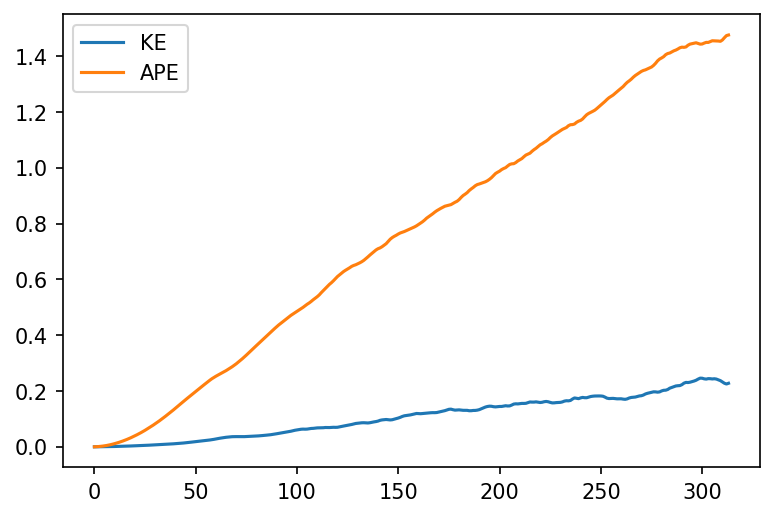

In [9]:
plt.plot(KE[0:314], label="KE")
plt.plot(APE[0:314], label="APE")
plt.legend(frameon=True)
plt.show()

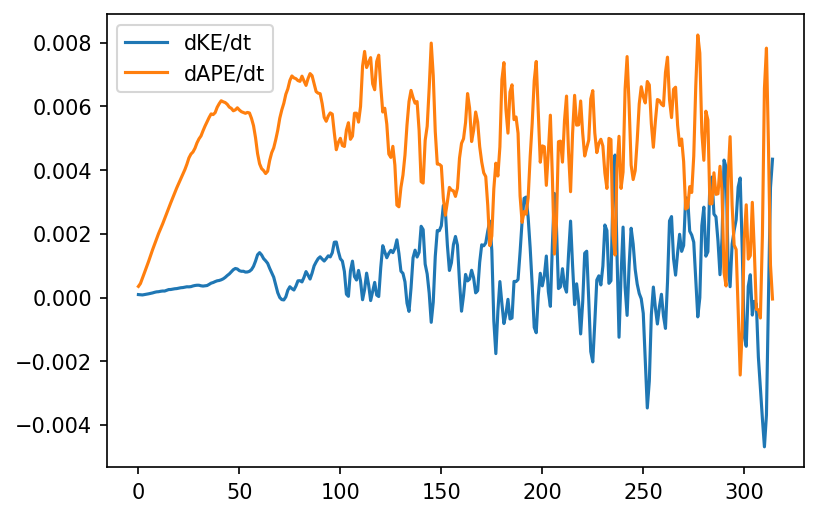

In [10]:
APEderiv = np.gradient(APE[0:315])
KEderiv = np.gradient(KE[0:315])

plt.plot(KEderiv, label="dKE/dt")
plt.plot(APEderiv, label="dAPE/dt")
plt.legend(frameon=True)
plt.show()

In [6]:
def zonal_winds(files, layer, reverse, rdist, dists, L):
    rootgroups = []
    for file in files:
        rootgroups.append(Dataset(file, "r"))
        
    if layer == 1:
        u = np.array(rootgroups[0].variables['u1mat'])
        for i in range(1,len(rootgroups)):
            data = np.array(rootgroups[i].variables['u1mat'])

            u = np.append(u, data[1:], axis=0)
        
        
        v = np.array(rootgroups[0].variables['v1mat'])
        for i in range(1,len(rootgroups)):
            data = np.array(rootgroups[i].variables['v1mat'])

            v = np.append(v, data[1:], axis=0)
    
    if layer == 2:
        u = np.array(rootgroups[0].variables['u2mat'])
        for i in range(1,len(rootgroups)):
            data = np.array(rootgroups[i].variables['u2mat'])

            u = np.append(u, data[1:], axis=0)


        v = np.array(rootgroups[0].variables['v2mat'])
        for i in range(1,len(rootgroups)):
            data = np.array(rootgroups[i].variables['v2mat'])
            
            v = np.append(v, data[1:], axis=0)
    
    zonal = 1/np.sqrt(x**2 + y**2) * (-y*u + x*v)
    
    """
    rdist = np.round(rdist, 1)
    dists = np.unique(rdist)
    
    zonals = []
    mean_zonals = []
    for i in range(reverse):
        mean_zonal = []
        for dist in dists:
            inds = np.array(list(zip(*np.where(rdist == dist))))

            zonals.append(zonal[zonal.shape[0]-i-1, inds[:,0],inds[:,1]])

            mean_winds = np.mean(zonal[zonal.shape[0]-i-1, inds[:,0],inds[:,1]])

            mean_zonal.append(mean_winds)
        
        mean_zonals.append(mean_zonal)
    """
    
    return zonal #, mean_zonals, zonals, dists



def fourier_coeff(zonal, inds, N):

    poss = inds - N/2

    ns = np.arange(1,20)
    cs = []
    for n in ns:
        first = 0
        second = 0
        for i in range(len(inds)):
            theta = np.arctan2(poss[i][1], poss[i][0])
            first += zonal[-1][inds[i][0]][inds[i][1]] * np.cos(n*theta)
            second += zonal[-1][inds[i][0]][inds[i][1]] * np.sin(n*theta)


        cs.append( 1/(4*np.pi**2) * (first**2 + second**2) )

    return cs


In [ ]:
x, y = np.meshgrid(np.arange(0, N) * dx - L / 2, np.arange(0, N) * dx - L / 2)
rdist = np.sqrt((x**2) + (y**2))

rdist = np.round(rdist, 1)
dists = np.unique(rdist) 

layer = 2
zonal = zonal_winds(data, layer, rdist, dists, 10, L) # , mean_zonals, zonals, dists = zonal_winds(data, layer, 10, rdist)

In [ ]:
allcs = []
for dist in dists:
    inds = np.array(list(zip(*np.where(rdist == dist))))
    cs = fourier_coeff(zonal, inds, N)

    allcs.append(cs)

allcs = np.array(allcs)

In [ ]:
fig, axs = plt.subplots(1, 2)
ax = axs[0]
x = np.arange(1,20)
y = dists
im = ax.pcolormesh(x, y, np.sqrt(allcs), cmap='bwr', shading='nearest')
ax.xaxis.set_ticks(np.arange(2, 20, 2))
ax.set_xlabel("wavenumber")
ax.set_ylabel("Radial distance [LD2]")
tx = ax.set_title("Wavenumer vs radial distance")
#fig.colorbar(im)


x, y = np.meshgrid(np.arange(0, N) * dx - L / 2, np.arange(0, N) * dx - L / 2)

ax2 = axs[1]
im2 = ax2.pcolormesh(x,y, zonal[-1], cmap='hot', shading='auto')
ax2.set_xlabel("x position [LD2]")
ax2.set_ylabel("y position [LD2]")
ax2.set_title("Zonal winds at last timestep")
fig.colorbar(im2)

plt.subplots_adjust(wspace=0.5)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
LD2 = 13
LD2ind = np.where(dists == LD2)[0][0]
plt.plot(np.arange(1,20), allcs[LD2ind])
plt.xticks(np.arange(1,20))
plt.xlabel('wavenumber')
plt.ylabel('strength')
plt.title(f'fourier wavenumber strengths at {dists[LD2ind]} LD2')
plt.show()